Results of effect of initial pts for annealing

and check whether SBI-SGM is stable under different runs

**results**

1. Ann's performance is stable for the initial pt selection.

2. Ann's parameters can be very different depending on the initial pt.

3. SBI's posteriors can be very different under different runs.


**So do not add the results in the manuscript**

### Import some useful pkgs

In [1]:
import os
import sys
import time
module_path = os.path.abspath(os.path.join('../mypkg'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [71]:
import pickle
import scipy
import torch
import umap

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr

from tqdm import trange, tqdm
from sbi import utils as sutils
from sbi import analysis as analysis
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from functools import partial
from easydict import EasyDict as edict
from pathlib import Path

#### Reload my modules

In [3]:
import importlib
#import constants
#importlib.reload(constants)

from utils.misc import meg_psd2spatialfeature, get_mode, load_pkl, save_pkl
from utils.standardize import stdz_psd, stdz_vec, minmax_vec, psd_2tr
from sgm.sgm import SGM
from spectrome import Brain, path, functions

from constants import RES_ROOT, FIG_ROOT, DAT_ROOT

### Some functions

In [4]:
def _simulate_data(params, sgmmodel):
    """The function to simulate samples
    """
    psd, spatialFs = sgmmodel.run_local_coupling_forward(params)
    psd = psd[:68, :]
    spatial_fs = spatialFs.sum(axis=1)
    
    std_psd_DB = psd_2tr(psd)
    psd_fs = std_psd_DB.flatten()
    
    res = np.concatenate([psd_fs, spatial_fs]) 
    return res

### Load real data PSD and brain

#### PSD and connectome

In [5]:
# Load data
ind_psd_xr = xr.open_dataarray(DAT_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
FREQS = ind_psd_xr["frequencies"].values
ind_conn_xr = xr.open_dataarray(DAT_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values


#### data for brain plots

In [6]:
# Get reorder indeix
# dk86.***.txt is the order for the MEG data
# DK68_labelorder.xlsx is the order for the template
dk_brainnet = pd.read_excel(DAT_ROOT/"DK68_labelorder.xlsx")
with open(DAT_ROOT/'dk86atlas_regions_python.txt') as f:
    dk_python = f.readlines()
    
brainnet_order = dk_brainnet["Order in Brainstorm"]
dk_python_renamed = []
brainnet_renamed = []

for i in range(len(dk_python)):
    sp1 = dk_python[i].split('=')
    sp2 = sp1[1].split('_')
    dk_python_renamed.append((sp2[0] + ' ' + sp2[1]).lower().strip())

for i in range(len(brainnet_order)):
    brainnet_renamed.append((brainnet_order[i].replace("'","")).lower())

d = {x: a for a, x in enumerate(dk_python_renamed[0:68])}
orderedind = np.array([d[x] for x in brainnet_renamed])

In [7]:
def reorderU(wU):
    wUreorder = wU.copy()
    wUreorder = wUreorder[orderedind]
    return wUreorder

with open(DAT_ROOT/'BNVtemplate_DK68.txt', "r") as tf:
    DKtmplateRaw = tf.readlines()
DKtmplate = np.array([int(x.strip()) for x in DKtmplateRaw])

def U2BrainVec(wU):
    emVec = np.zeros_like(DKtmplate, dtype=np.float64)
    for idx in range(1, 69):
        emVec[DKtmplate==idx] = wU[idx-1]
    return emVec

#### Load parul's results

In [12]:
anl_res = pd.read_csv(DAT_ROOT/"./parul_results.csv")
anl_res1 = pd.read_csv(DAT_ROOT/"./parul_results_IC1.csv")
anl_res2 = pd.read_csv(DAT_ROOT/"./parul_results_IC2.csv")
anl_res3 = pd.read_csv(DAT_ROOT/"./parul_results_IC3.csv")

### Set up Parameters

#### Set up plotting

In [36]:
metd = edict()
metd.anl0 = "Ann-SGM-All"
metd.anl1 = "Ann-SGM-1"
metd.anl2 = "Ann-SGM-2"
metd.anl3 = "Ann-SGM-3"

plot_sets = edict()
plot_sets.col = ["dodgerblue", "coral", "red", "yellow"]
plot_sets.alpha = 0.8
plot_sets.marker = ["o", "h", "+", "*"]

#### Parameters

In [73]:
paras = edict()

paras.path = Path(RES_ROOT/"./main_results_nsf")

paras.robustParas = edict()
paras.robustParas.path = Path(paras.path/"robust_results")


paras.fig_dir = FIG_ROOT
paras.res_dir = RES_ROOT
paras.name_order = ['taue','taui','tauG','speed','alpha','gii','gei']
paras.name_order_latex = [r'$\tau_e$',r'$\tau_i$',r'$\tau_G$',r'$v$',r'$\alpha$',r'$g_{ii}$',r'$g_{ei}$']

In [17]:
# taue, taui, tauC, speed, alpha, gii, gei
par_low = np.asarray([0.005,0.005,0.005,1.7,0.1,0.5,0.5])
par_high = np.asarray([0.03, 0.20, 0.03,5.3,  1, 10, 10])
plotLimits = np.array([par_low, par_high]).T

In [18]:
prior = sutils.BoxUniform(low=torch.as_tensor(par_low), high=torch.as_tensor(par_high))

In [19]:
# obtain the brain
brain = Brain.Brain()
brain.add_connectome(DAT_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

sgmmodel = SGM(brain.reducedConnectome, brain.distance_matrix, FREQS)

In [42]:
# the estimated spatial feature from MEG
MEGSPs = []
MEGSPRaws = []
for ix in trange(36):
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
    
    curMEGSP, curMEGSPRaw = meg_psd2spatialfeature(curBrain.reducedConnectome, ind_psd[:, :, ix], FREQS)
    MEGSPs.append(curMEGSP)
    MEGSPRaws.append(curMEGSPRaw.sum(axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 63.17it/s]


### ANN


In [66]:
# taue, taui, tauC, speed, alpha, gii, gei
para_nams = ["taue", "taui", "tauC", "speed", "alpha", "gii", "gei"]
#para_nams = paras.name_order
def res_2vec(anl_res, ix=0):
    vec = np.array([anl_res[nam][ix] for nam in para_nams])
    vec[:3] = vec[:3]/1000
    return vec

In [67]:
anl_sgmPSDs = []
anl_sgmSPs = []
for ix in trange(36):
    curParas = res_2vec(anl_res, ix)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    curSgmModel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
    curPSD = curPSD[:68, :]
    curPSD = psd_2tr(curPSD)
        
    anl_sgmPSDs.append(curPSD)
    anl_sgmSPs.append(curSPs.sum(axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:42<00:00,  1.19s/it]


In [24]:
anl_sgmPSD1s = []
anl_sgmSP1s = []
for ix in trange(36):
    curParas = res_2vec(anl_res1, ix)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    curSgmModel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
    curPSD = curPSD[:68, :]
    curPSD = psd_2tr(curPSD)
        
    anl_sgmPSD1s.append(curPSD)
    anl_sgmSP1s.append(curSPs.sum(axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:43<00:00,  1.22s/it]


In [25]:
anl_sgmPSD2s = []
anl_sgmSP2s = []
for ix in trange(36):
    curParas = res_2vec(anl_res2, ix)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    curSgmModel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
    curPSD = curPSD[:68, :]
    curPSD = psd_2tr(curPSD)
        
    anl_sgmPSD2s.append(curPSD)
    anl_sgmSP2s.append(curSPs.sum(axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:44<00:00,  1.24s/it]


In [26]:
anl_sgmPSD3s = []
anl_sgmSP3s = []
for ix in trange(36):
    curParas = res_2vec(anl_res3, ix)
    curC = ind_conn[:, :, ix]
    curBrain = Brain.Brain()
    curBrain.add_connectome(DAT_ROOT) # grabs distance matrix
        # re-ordering for DK atlas and normalizing the connectomes:
    curBrain.reorder_connectome(curBrain.connectome, curBrain.distance_matrix)
    curBrain.connectome = curC# re-assign connectome to individual connectome
    curBrain.bi_symmetric_c()
    curBrain.reduce_extreme_dir()
        
    curSgmModel = SGM(curBrain.reducedConnectome, curBrain.distance_matrix, FREQS)
    curPSD, curSPs = curSgmModel.run_local_coupling_forward(curParas)
    curPSD = curPSD[:68, :]
    curPSD = psd_2tr(curPSD)
        
    anl_sgmPSD3s.append(curPSD)
    anl_sgmSP3s.append(curSPs.sum(axis=1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:44<00:00,  1.24s/it]


#### PSD curve

In [68]:
MEGPSDMean = np.mean([psd_2tr(ind_psd[:, :, ix]).mean(axis=0) for ix in range(36)], axis=0)
anl_PSD = np.array(anl_sgmPSDs).mean(axis=1).mean(axis=0)
anl_PSD1 = np.array(anl_sgmPSD1s).mean(axis=1).mean(axis=0)
anl_PSD2 = np.array(anl_sgmPSD2s).mean(axis=1).mean(axis=0)
anl_PSD3 = np.array(anl_sgmPSD3s).mean(axis=1).mean(axis=0)

anl_cor = scipy.stats.pearsonr(stdz_vec(MEGPSDMean), stdz_vec(anl_PSD))[0]
anl_cor1 = scipy.stats.pearsonr(stdz_vec(MEGPSDMean), stdz_vec(anl_PSD1))[0]
anl_cor2 = scipy.stats.pearsonr(stdz_vec(MEGPSDMean), stdz_vec(anl_PSD2))[0]
anl_cor3 = scipy.stats.pearsonr(stdz_vec(MEGPSDMean), stdz_vec(anl_PSD3))[0]

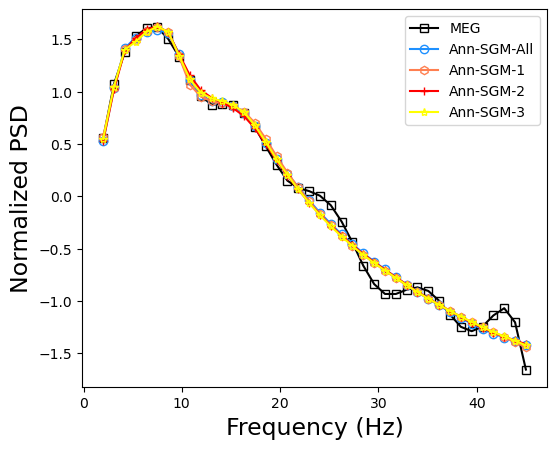

In [69]:
plt.figure(figsize=[6, 5], dpi=100)
plt.plot(FREQS, stdz_vec(MEGPSDMean), linestyle = '-',marker = 's',
         fillstyle = 'none',color = 'k', 
         label = "MEG")
plt.plot(FREQS, stdz_vec(anl_PSD), linestyle = '-',marker=plot_sets.marker[0],
         fillstyle = 'none',color = plot_sets.col[0], 
         label = metd.anl0)
plt.plot(FREQS, stdz_vec(anl_PSD1), linestyle = '-',marker=plot_sets.marker[1],
         fillstyle = 'none',color = plot_sets.col[1], 
         label = metd.anl1)
plt.plot(FREQS, stdz_vec(anl_PSD2), linestyle = '-',marker=plot_sets.marker[2],
         fillstyle = 'none',color = plot_sets.col[2], 
         label = metd.anl2)
plt.plot(FREQS, stdz_vec(anl_PSD3), linestyle = '-',marker=plot_sets.marker[3],
         fillstyle = 'none',color = plot_sets.col[3], 
         label = metd.anl3)
plt.xlabel('Frequency (Hz)', fontsize = 17)
plt.ylabel('Normalized PSD', fontsize = 17)
plt.legend()

#plt.savefig(FIG_ROOT/"PSD_compare.jpg", bbox_inches="tight")

In [40]:
MEG_psd_each_ROIs = np.array([psd_2tr(ind_psd[:, :, ix]) for ix in range(36)])
anl_PSD_corrs = []
for ix in range(MEG_psd_each_ROIs.shape[0]):
    curMEG = MEG_psd_each_ROIs[ix]
    curSGM = anl_sgmPSDs[ix]
    anl_PSD_corrs.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
    
anl_PSD_corrs1 = []
for ix in range(MEG_psd_each_ROIs.shape[0]):
    curMEG = MEG_psd_each_ROIs[ix]
    curSGM = anl_sgmPSD1s[ix]
    anl_PSD_corrs1.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))
    
anl_PSD_corrs2 = []
for ix in range(MEG_psd_each_ROIs.shape[0]):
    curMEG = MEG_psd_each_ROIs[ix]
    curSGM = anl_sgmPSD2s[ix]
    anl_PSD_corrs2.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))

anl_PSD_corrs3 = []
for ix in range(MEG_psd_each_ROIs.shape[0]):
    curMEG = MEG_psd_each_ROIs[ix]
    curSGM = anl_sgmPSD3s[ix]
    anl_PSD_corrs3.append(np.mean([scipy.stats.pearsonr(curMEG[iz], curSGM[iz])[0] for iz in range(68)]))

In [43]:
anl_SP_corrs = []
for mv, ov in zip(anl_sgmSPs, MEGSPs):
    anl_SP_corrs.append(np.dot(mv/np.linalg.norm(mv), ov))
    
anl_SP_corrs1 = []
for mv, ov in zip(anl_sgmSP1s, MEGSPs):
    anl_SP_corrs1.append(np.dot(mv/np.linalg.norm(mv), ov))
    
anl_SP_corrs2 = []
for mv, ov in zip(anl_sgmSP2s, MEGSPs):
    anl_SP_corrs2.append(np.dot(mv/np.linalg.norm(mv), ov))
    
anl_SP_corrs3 = []
for mv, ov in zip(anl_sgmSP3s, MEGSPs):
    anl_SP_corrs3.append(np.dot(mv/np.linalg.norm(mv), ov))

#### PSD and SP corrs

In [44]:
SP_all = np.array([anl_SP_corrs, anl_SP_corrs1, anl_SP_corrs2, anl_SP_corrs3])
PSD_all = np.array([anl_PSD_corrs, anl_PSD_corrs1, anl_PSD_corrs2, anl_PSD_corrs3])

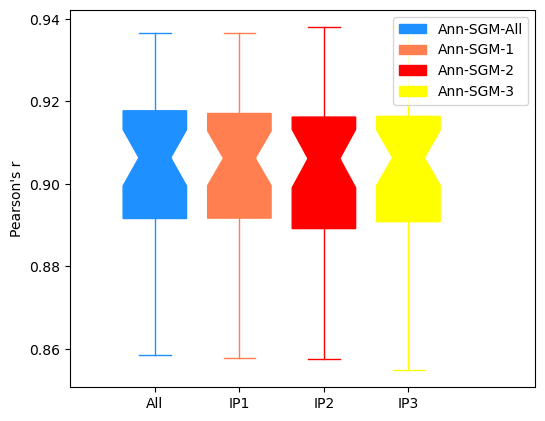

In [51]:
plt.figure(figsize=[6, 5], dpi=100)
box = plt.boxplot(PSD_all.T[:, 0], positions=[0.4],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[0])
box0 = box
    
box = plt.boxplot(PSD_all.T[:, 1], positions=[0.6],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[1])
box1 = box

box = plt.boxplot(PSD_all.T[:, 2], positions=[0.8],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[2])
box2 = box

box = plt.boxplot(PSD_all.T[:, 3], positions=[1.0],
                  notch=True, showfliers=False,  patch_artist=True);
for item in ['boxes', 'whiskers',  'medians', 'caps']:
    plt.setp(box[item], color=plot_sets.col[3])
box3 = box
    
#box = plt.boxplot(SP_all.T[:, 0], positions=[.9],
#                  notch=True, showfliers=False,  patch_artist=True);
#for item in ['boxes', 'whiskers',  'medians', 'caps']:
#    plt.setp(box[item], color=plot_sets.col[0])
#    
#box = plt.boxplot(SP_all.T[:, 1], positions=[1.1],
#                  notch=True, showfliers=False,  patch_artist=True);
#for item in ['boxes', 'whiskers',  'medians', 'caps']:
#    plt.setp(box[item], color=plot_sets.col[1])
plt.xlim([0.2, 1.3])

plt.xticks([0.4, 0.6, 0.8, 1.0], ["All", "IP1", "IP2", "IP3"])
plt.ylabel("Pearson's r")
plt.legend([box0["boxes"][0], 
            box1["boxes"][0], 
            box2["boxes"][0], 
            box3["boxes"][0], 
           ], 
           [metd.anl0, 
            metd.anl1,
            metd.anl2,
            metd.anl3,
           ])

### SBI

In [74]:
fils = list(paras.robustParas.path.glob("robustSps_100000_sd20_*.pkl"))

tmpSortFn = lambda p: int(p.stem.split("_")[-1])
sorted_fils = sorted(fils, key=tmpSortFn)

In [100]:
def _spss_2hist(spss, bds, bins=20):
    assert spss.shape[1] == 7
    assert bds.shape[0] == 7
    hist_ress = []
    for ix in range(7):
        sps = spss[:, ix]
        bd = bds[ix, :]
        hist_res_ = np.histogram(sps, bins, bd)
        hist_ress.append(hist_res_)
    
    return hist_ress

In [111]:
res0 = load_pkl(sorted_fils[0])
res1 = load_pkl(sorted_fils[2])

Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_1.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/SBI-SGM/mypkg/../results/main_results_nsf/robust_results/robustSps_100000_sd20_3.pkl


In [115]:
sub_idx = 1
para_idx = 1
hists0 = _spss_2hist(res0.postSpss[sub_idx].numpy(), plotLimits)
hists1 = _spss_2hist(res1.postSpss[sub_idx].numpy(), plotLimits)
for para_idx in range(7):
    print(scipy.stats.pearsonr(hists0[para_idx][0], hists1[para_idx][0]))

(0.3169601628154673, 0.17331312536151855)
(0.031587906051702926, 0.8948247159335699)
(0.023695612767765602, 0.9210112031372267)
(-0.030626425532875423, 0.8980098238711895)
(0.9859098374827893, 1.975579367221798e-15)
(-0.05494176563394273, 0.8180456875238091)
(0.036918898877897045, 0.8771940509268665)
